# 2. Run an election

In this notebook, I will explain how to run an election on a voting profile with embedded voters.

In [1]:
import numpy as np
import embedded_voting as ev
import matplotlib.pyplot as plt

np.random.seed(42)

## Creating the profile

Let's say we have **5 candidates** and **3 groups** of voters :

   * The **<font color="red">red group</font>** contains **50%** of the voters, and the average scores of candidates given by this group are $[0.9,0.3,0.5,0.2,0.2]$.
   * The **<font color="green">green group</font>** contains **25%** of the voters, and the average scores of candidates given by this group are $[0.2,0.6,0.5,0.5,0.8]$.
   * The **<font color="blue">blue group</font>** contains **25%** of the voters, and the average scores of candidates given by this group are $[0.2,0.6,0.5,0.8,0.5]$.

In [2]:
scores_matrix = np.array([[.9, .3, .5, .3, .2], [.2, .6, .5, .5, .8], [.2, .6, .5, .8, .5]])
proba = [.5, .25, .25]
    
profile = ev.ParametricProfile(5, 3, 100, scores_matrix, proba)
profile.set_parameters(polarisation=0.4, coherence=0.8)

We can **visualize** this profile, as explained in the first notebook :

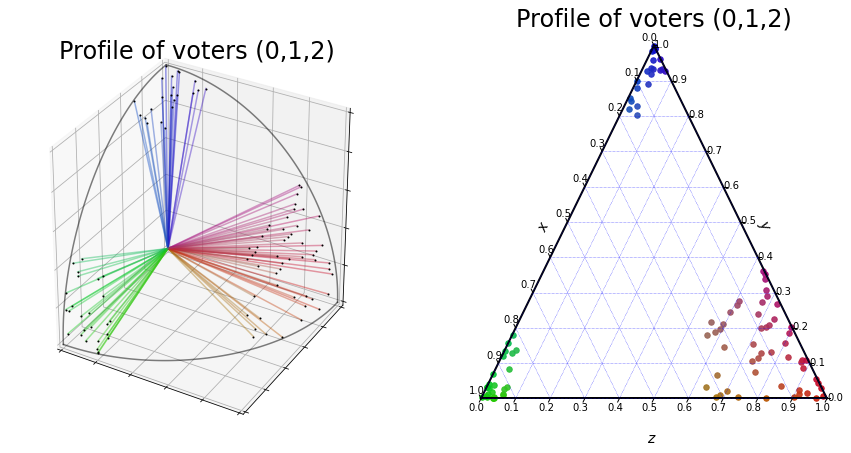

In [3]:
fig = plt.figure(figsize=(15,7.5))
profile.plot_profile("3D", fig=fig, position=[1,2,1], show=False)
profile.plot_profile("ternary", fig=fig, position=[1,2,2], show=False)
plt.show()

And we can also **visualize the candidates**. Each voter is represented by a line and the length of the line represents the score the voter gives to the candidate.

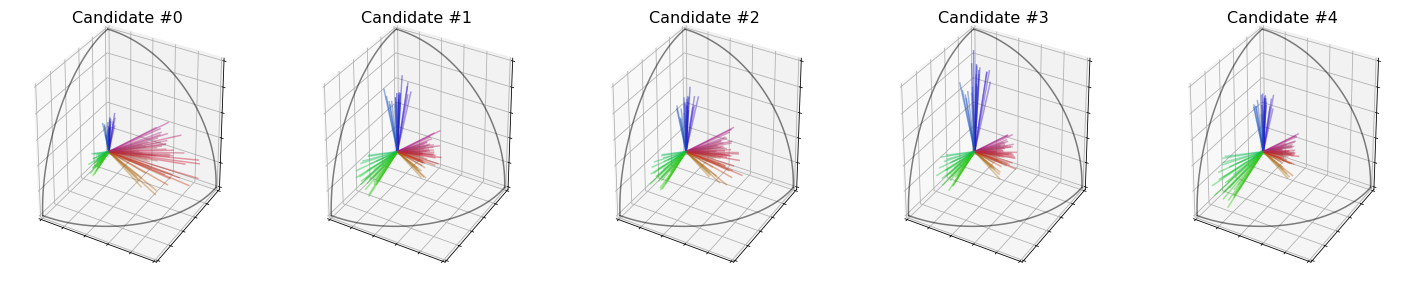

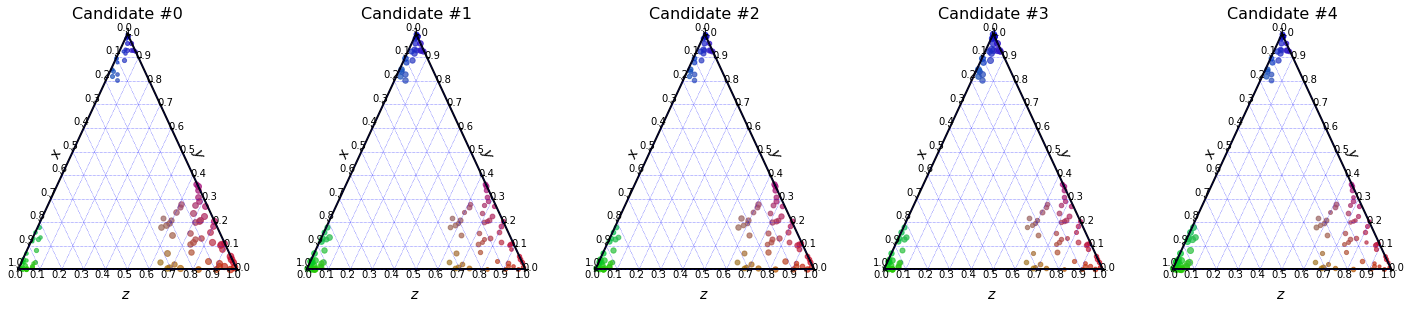

In [4]:
profile.plot_candidates("3D")
profile.plot_candidates("ternary")

Now, we want to determine the **best candidate**. Is it the *Candidate 0*, which is loved by the majority group? Or is it the *Candidate 2*, which is not hated by any group ?

To decide that, we can use a whole set of voting rules. First, there is the **simple rules**, which are not based on the embeddings. These rules are *Range voting* (we take the average score) and *Nash voting* (we take the product of the score, or the average log score).

## Notations

In the following parts of the notebook, I will use some notations :

| Notation  | Meaning               | Function |
|-----------|-----------------------|----------|
| $v_i$     | The $i^{th}$ voter    |           |
| $c_j$     | The $j^{th}$ candidate|           |
| $s_i(c_j)$| The score given by the voter $v_i$ to the candidate $c_j$| <tt>Profile.scores[i,j]</tt> |
| $S(c_j)$  | The score of the candidate $c_j$ after the aggregation |  <tt>ScoringRule.scores_[j]</tt> |
| $w(c_j)$  | The welfare of candidate $c_j$ | <tt> ScoringRule.welfare_[j] </tt> |
| $M$       | The embeddings matrix, such that $M_i$ are the embeddings of $v_i$| <tt>Profile.embeddings</tt> |
| $M(c_j)$  | The candidate matrix, such that $M(c_j)_i = s_i(c_j)\times M_i$| <tt>Profile.scored_embeddings(j)</tt> |
| $s^*(c_j)$     | The vector of score of one candidate, such that $s^*(c_j)_i = s_i(c_j)$| <tt>Profile.scores[:,j]</tt> |




## Simple rules

### Average score *(Nash voting)*

This is the **most intuitive rule** when we need to aggregate the score of the different voters to establish a ranking of the candidate. We simply take the sum of every vote given to this candidate :

$$
\forall j, S(c_j) = \sum_i s_i(c_j)
$$

We create the election in the following cell.

In [5]:
election = ev.SumScores(profile)

We can also **change** the profile of voter of the election by calling the election on a new profile.

In [6]:
election = ev.SumScores()
election(profile)

Then, we can compute the **score** of every candidate, their **ranking**, and of course the **winner** of the election :

In [8]:
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)

Scores :  [48.62622353783491, 48.79049440707229, 50.16487905177754, 50.11006620672806, 48.25756906818151]
Ranking :  [2, 3, 1, 0, 4]
Winner :  2


We can also compute the welfare of each candidate, where the welfare is defined as :

$$
w(c_j) = \frac{S(c_j) - \min_c S(c)}{\max_c S(c) - \min_c S(c)}
$$

In [9]:
print('Welfare : ', election.welfare_)

Welfare :  [0.19328503118215812, 0.27941202189169245, 1.0, 0.9712617007613313, 0.0]


We can **plot the winner** of the election using the function <tt>plot_winner()</tt>.

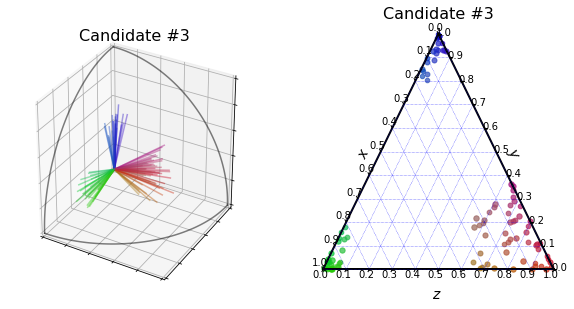

In [10]:
fig = plt.figure(figsize=(10,5))
election.plot_winner("3D", fig=fig, position=[1,2,1], show=False)
election.plot_winner("ternary", fig=fig, position=[1,2,2], show=False)
plt.show()

We can **plot the ranking** of the election using the function <tt>plot_ranking()</tt>.

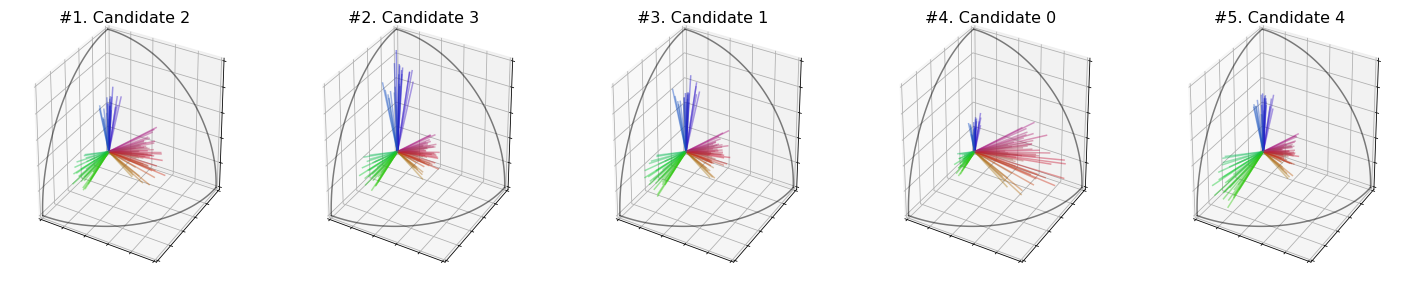

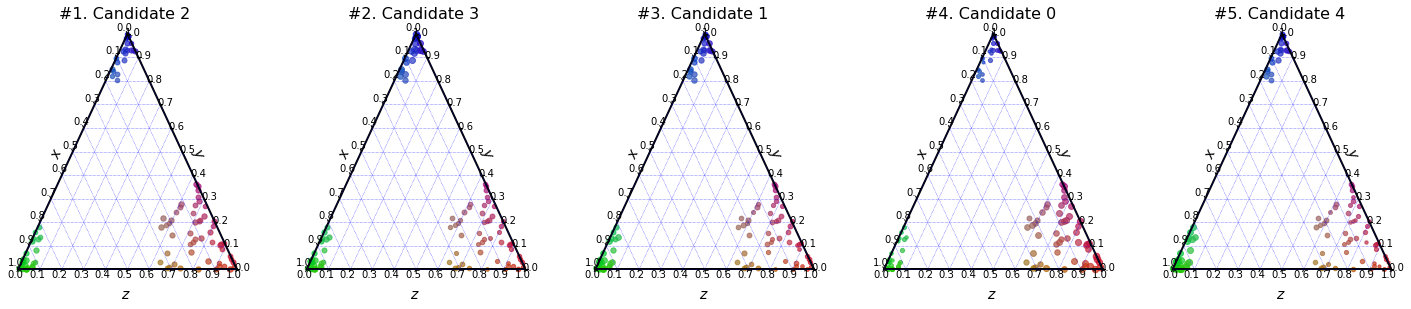

In [11]:
election.plot_ranking("3D")
election.plot_ranking("ternary")

### Product of scores (Nash)

The second intuitive rule is **the product of the scores**, also called *Nash welfare*. It is equivalent to the sum of the log of the scores.

We have

$$
S(c_j) = \prod_i s_i(c_j) = e^{\sum_i \log(s_i(c_j))}
$$

Scores :  [(100, 5.393919173647501e-37), (100, 4.7326054849600145e-33), (100, 5.081774294049027e-31), (100, 2.4593338907274875e-32), (100, 3.2576919258312143e-35)]
Ranking :  [2, 3, 1, 4, 0]
Winner :  2


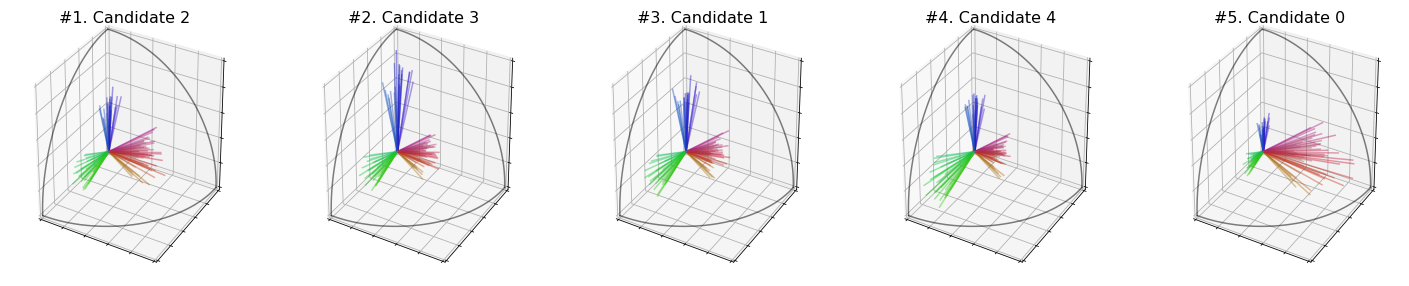

In [12]:
election = ev.ProductScores(profile)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
election.plot_ranking("3D")

You probably notice that scores are **composed of two elements** (e.g <tt>(100, 5.393919173647501e-37)</tt>). In this particular case, the first element is the number of non-zero scores and the second one is the product of the non-zero scores. Indeed, if some voter gives a score of $0$ to every candidate, the product of scores will be $0$ for every candidate and we cannot establish a ranking.

We use similar ideas for some of the rules that will come later. 

In these cases, if we have $S(c_j) = \left ( S(c_j)_1 , S(c_j)_2 \right )$, the score used in the welfare is :

$$
S'(c_j) = 
\begin{cases}
    S(c_j)_2& \text{if } S(c_j)_1 = \max_c S(c)_1 \\
    0              & \text{Otherwise}
\end{cases}
$$

In other word, the welfare is $> 0$ only if the first component of the score is at the maximum.

In [14]:
print("Welfare : ",election.welfare_)

Welfare :  [0.0, 0.009311848267877218, 1.0, 0.048394171397146954, 6.304404621809688e-05]


## Geometrical rules

All the rules that I will describe now are **using the embeddings** of the voters. Some of them are purely **geometrical**, other are more **algebraic**. Let's start with the geometrical ones.

All of the rules presented here **do not depend on the basis** used for the embeddings. Indeed, the result will not change if you change the vector basis of the embeddings (for instance, by doing a **rotation**) 

### Zonotope

The zonotope of a set of vectors $V = \{\vec{v_1}, \ldots, \vec{v_n}\}$
is the geometrical object defined as $\mathcal{Z}(V) = \{ \sum_i t_i \vec{v_i} | \forall i, t_i \in [0,1] \}$.

For a matrix $M$, we have $\mathcal Z (M) = \mathcal Z (\{ M_1, \ldots, M_n \})$.

The following figure illustrate the zonotope in 2D for a set of 4 vectors.

In the case of an election, the score of the candidate $c_j$ is defined as the volume of the Zonotope defined by the row of the matrix $M(c_j)$ :

$$
S(c_j) = \text{vol}(\mathcal Z(M(c_j)))
$$

There is a simple formula to compute this volume, but it is **exponential in the number of dimensions**.


Scores :  [(3, 10205.867220392076), (3, 13090.32264649256), (3, 13314.331816009162), (3, 13655.74611406652), (3, 12510.717704925983)]
Ranking :  [3, 2, 1, 4, 0]
Winner :  3
Welfare :  [0.0, 0.8361033865244667, 0.9010358599302251, 1.0, 0.668096056577518]


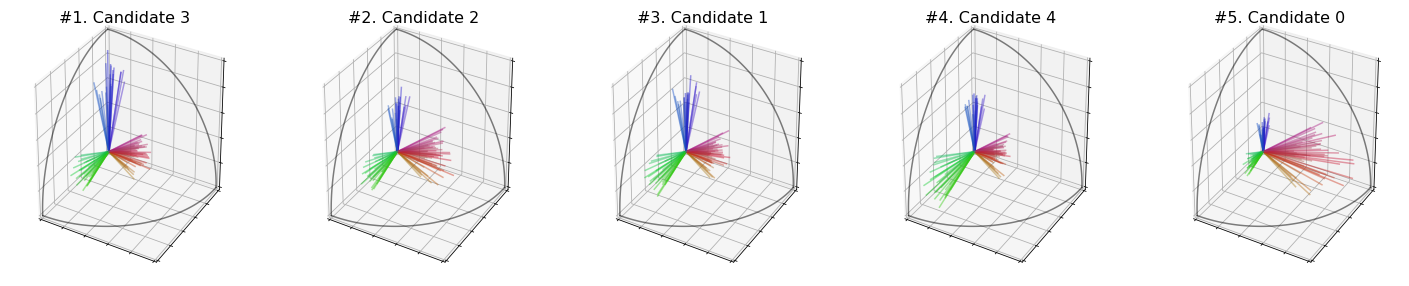

In [15]:
election = ev.ZonotopeRule(profile)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

### MaxCube

The maxcube rule is also very geometrical. It computes **the maximum volume** spanned by a linearly independent subset of rows of the matrix $M(c_j)$.

The figures below show an example of how it works.

Scores :  [(3, 0.31504099846254685), (3, 0.4056903762704473), (3, 0.42683661962352876), (3, 0.4537957511376097), (3, 0.3700146198939667)]
Ranking :  [3, 2, 1, 4, 0]
Winner :  3
Welfare :  [0.0, 0.6533064710236194, 0.8057066082830755, 1.0, 0.3961927095942983]


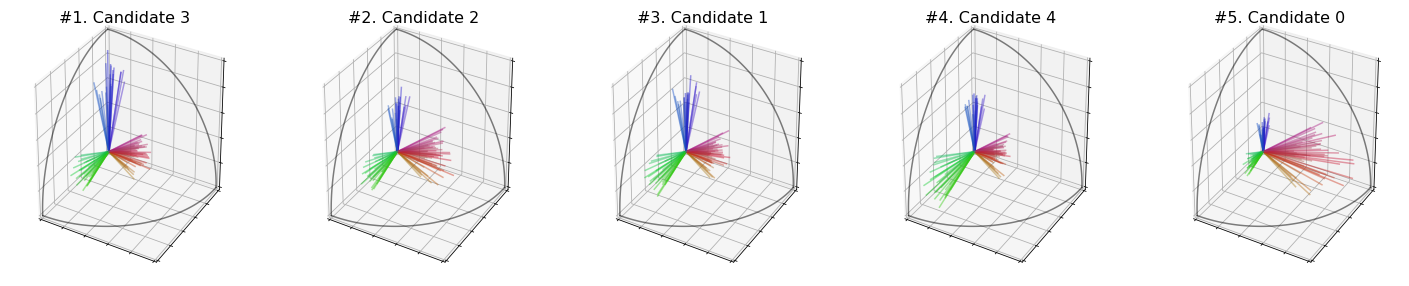

In [16]:
election = ev.MaxCubeRule(profile)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

### SVD Based rules

Here are some of the most interesting rules you can use for embedded voters. They are based on the **Singular Values Decomposition (SVD)** of the matrices $M(c_j)$.

Indeed, if we denote $(\sigma_1(c_j), \ldots, \sigma_n(c_j))$ the **singular values** of the matrix $M(c_j)$, then the <tt>SVDRule()</tt> while simply apply the <tt>aggregation_rule</tt> passed as parameter to them.

**Singular values** are very interesting in this context because each $\sigma_k$ represent one group of voter.

In the following cell, I use the product function, that means that we compute the score with the following formula :

$$
S(c_j) = \prod_k \sigma_k(c_j)
$$


Scores :  [34.742152381734435, 48.62228837794011, 48.150370603482465, 51.3628664628163, 46.861427327028686]
Ranking :  [3, 1, 2, 4, 0]
Winner :  3
Welfare :  [0.0, 0.8351106894982575, 0.8067173381563442, 1.0, 0.7291669230438619]


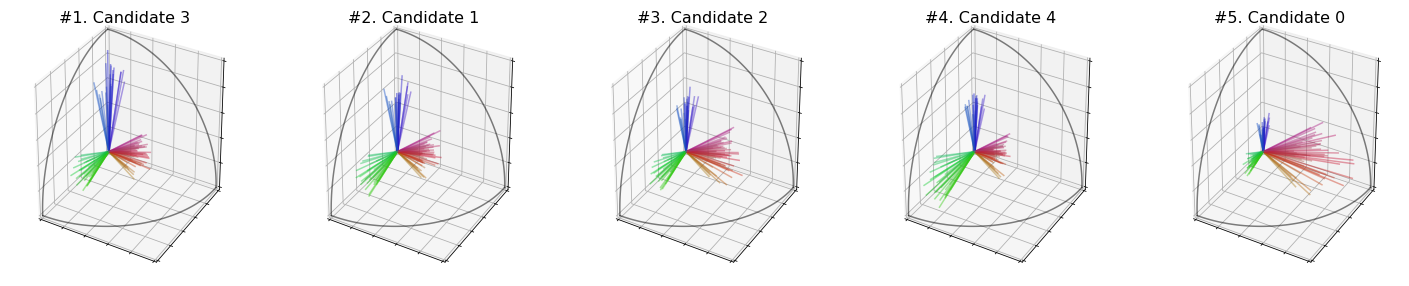

In [17]:
election = ev.SVDRule(profile, aggregation_rule=np.prod, use_rank=False, square_root=True)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

However, if you want to takes the **product** of the singular values, you can directly use <tt>SVDNash()</tt>, as in the following cell.

This rule is a great rule because the score is equal to **the volume of the matrix** $M(c_j)$. Indeed, we have :

$$
S(c_j) = \prod_k \sigma_k(c_j) = \text{det}(M(c_j)^tM(c_j)) = \text{det}(M(c_j)M(c_j)^t)
$$

Which is often described as the volume of a matrix.

Scores :  [34.742152381734435, 48.62228837794011, 48.150370603482465, 51.3628664628163, 46.861427327028686]
Ranking :  [3, 1, 2, 4, 0]
Winner :  3
Welfare :  [0.0, 0.8351106894982575, 0.8067173381563442, 1.0, 0.7291669230438619]


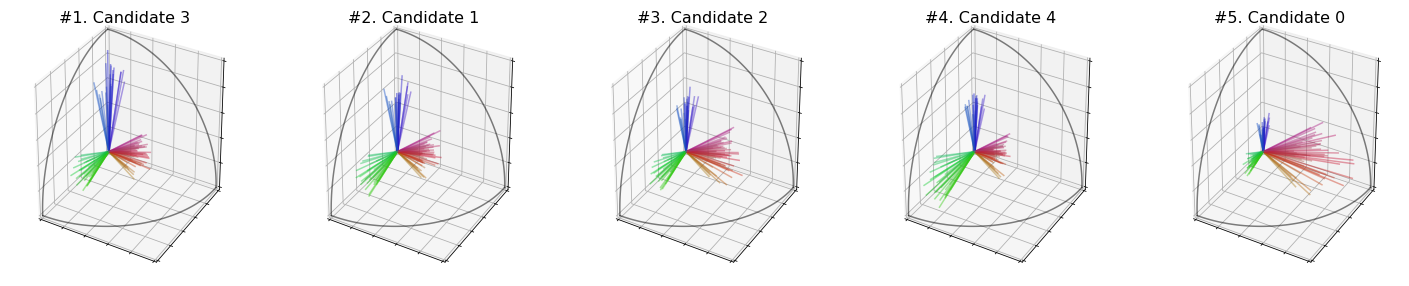

In [18]:
election = ev.SVDNash(profile, use_rank=False)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

You can takes the **sum** of the singular values with <tt>SVDSum()</tt> :

$$
S(c_j) = \sum_k \sigma_k(c_j)
$$

This correspond to an **utilitarian** approach of the election.

Scores :  [10.879908967988701, 11.500525032729435, 11.562123884099584, 11.681304321662514, 11.405803424625816]
Ranking :  [3, 2, 1, 4, 0]
Winner :  3
Welfare :  [0.0, 0.774419344828569, 0.8512838425920807, 1.0, 0.6562234909726795]


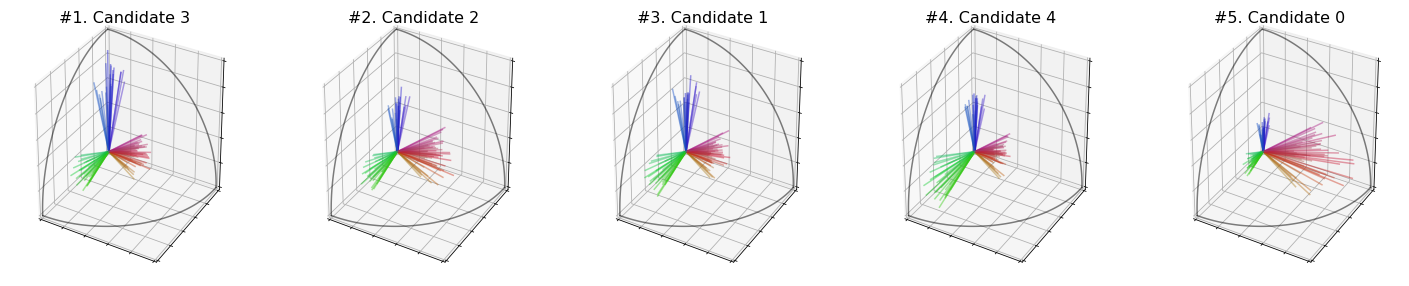

In [19]:
election = ev.SVDSum(profile, use_rank=False)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

You can takes the **minimum** of the singular values with <tt>SVDMin()</tt> :

$$
S(c_j) = \min_k \sigma_k(c_j)
$$

This correspond to an **egalitarian** approach of the election.

Scores :  [2.2225136894836863, 2.7725090928608025, 2.7052615523141035, 2.929432813419398, 2.601829703920355]
Ranking :  [3, 1, 2, 4, 0]
Winner :  3
Welfare :  [0.0, 0.7780174347456664, 0.6828898051912359, 1.0, 0.536576252633907]


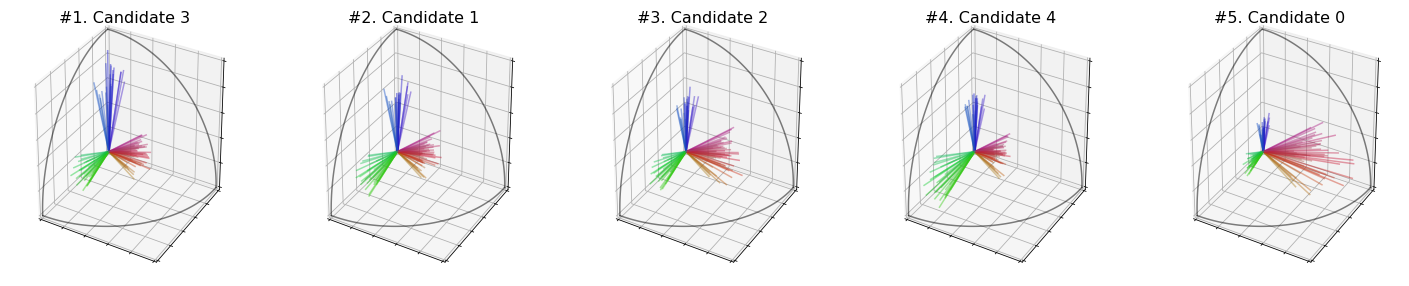

In [20]:
election = ev.SVDMin(profile, use_rank=False)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

You can takes the **maximum** of the singular values with <tt>SVDMin()</tt> :

$$
S(c_j) = \min_k \sigma_k(c_j)
$$

For single winner voting, this rule seems not very suited, because it will only maximize the satisfaction of **one group**. But it can be very useful **for multi-winner voting** (see the dedicated notebook).

Scores :  [6.090998682455975, 5.591720601981414, 5.774617223473266, 5.646931849707806, 5.570976728260722]
Ranking :  [0, 2, 3, 1, 4]
Winner :  0
Welfare :  [1.0, 0.039890380691317937, 0.3915998037576751, 0.1460613745906677, 0.0]


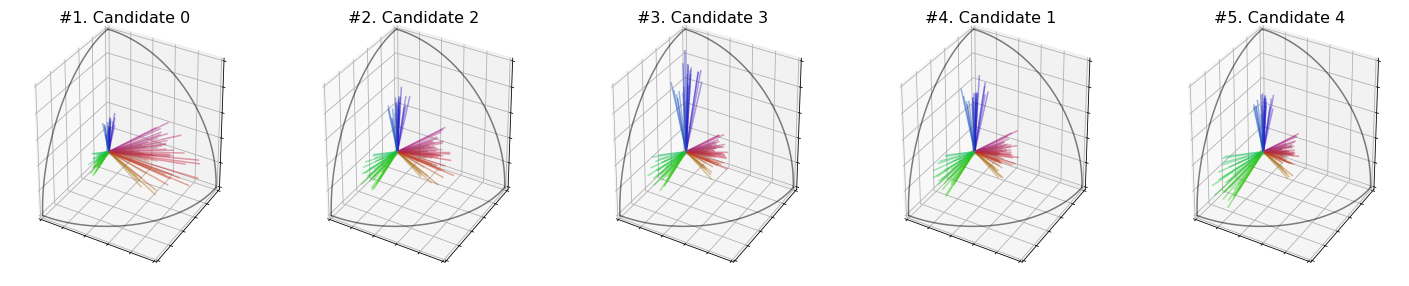

In [22]:
election = ev.SVDMax(profile, use_rank=False)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

Finally, there is the <tt>SVDLog()</tt> rule, which is a bit more exotic. It corresponds to the following equation :

$$
S(c_j) = \sum_k \text{log} \left (1 + \frac{\sigma_k(c_j)}{C} \right )
$$

where $C$ is a constant passed as parameter (its default value is $1$).

Scores :  [2.9704656428984224, 3.1468209674094716, 3.145857159662323, 3.1802955252361516, 3.1263186824285323]
Ranking :  [3, 1, 2, 4, 0]
Winner :  3
Welfare :  [0.0, 0.8404681094335201, 0.8358748277883563, 1.0, 0.7427590283792778]


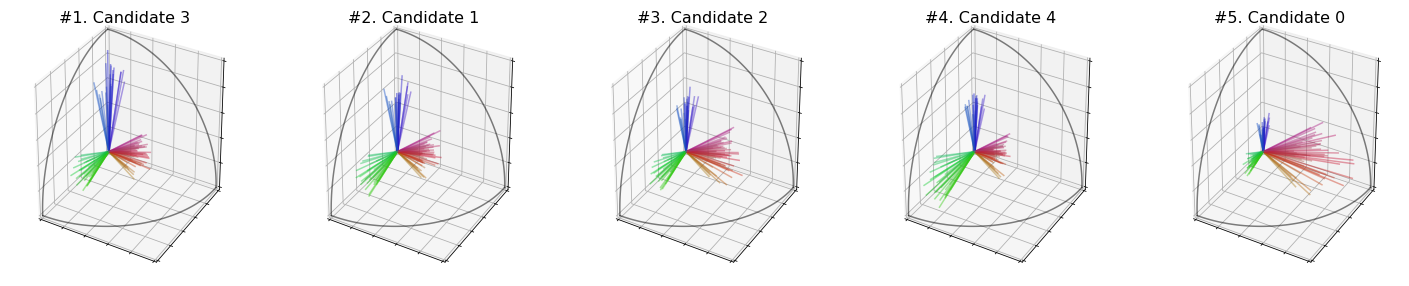

In [24]:
election = ev.SVDLog(profile, const=2, use_rank=False)
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")

The following table summarize the different rules based on the **SVD** :

|    Name    |      Equation                          | Interpretation        |
|------------|-----------------------------------------------------------|-----------------------|
| SVDNash    |  $$S(c_j) = \prod_k \sigma_k(c_j)$$                      | Nash Welfare          |
| SVDSum     |  $$S(c_j) = \sum_k  \sigma_k(c_j)$$                         | Utilitarian           |
| SVDMin     |  $$S(c_j) = \min_k  \sigma_k(c_j)$$                         | Egalitarian           |
| SVDMax     |  $$S(c_j) = \max_k  \sigma_k(c_j)$$                         | Dictature of majority |
| SVDLog     |  $$S(c_j) = \sum_k \text{log}\left (1+\frac{\sigma_k(c_j)}{C} \right ) $$|  Between Nash and Utilitarian  |

### Features based rule

The next rule is based on what is often called *features* in machine learning.

Indeed, it consist in **solving the linear regression** on $MX_j = s^*(c_j)$ for every candidate $c_j$. We want the vector $X_j$ such that 

$$
X_j = \min_{X}  ||MX - s^*(c_j) ||_2^2
$$

It corresponds to $X_j = (M^tM)^{-1}Ms^*(c_j)$. This is the classic features vector for candidate $c_j$.

In the following cell, the **features** of every candidate are shown on the 3D plots.

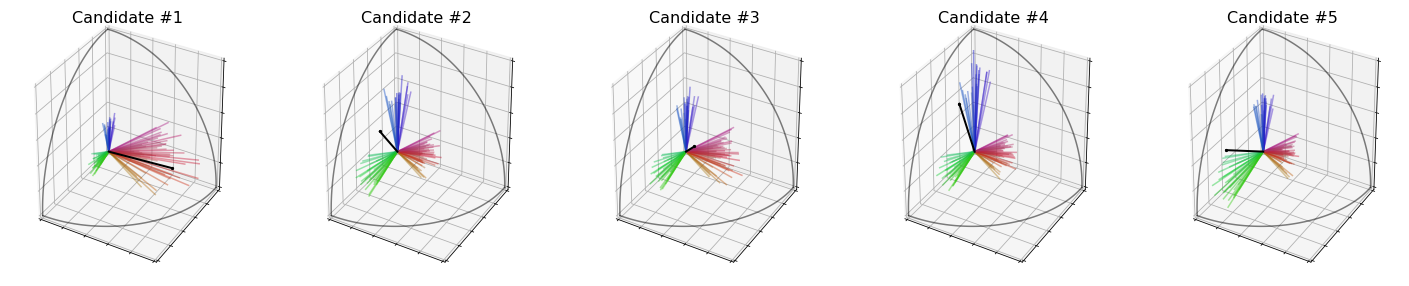

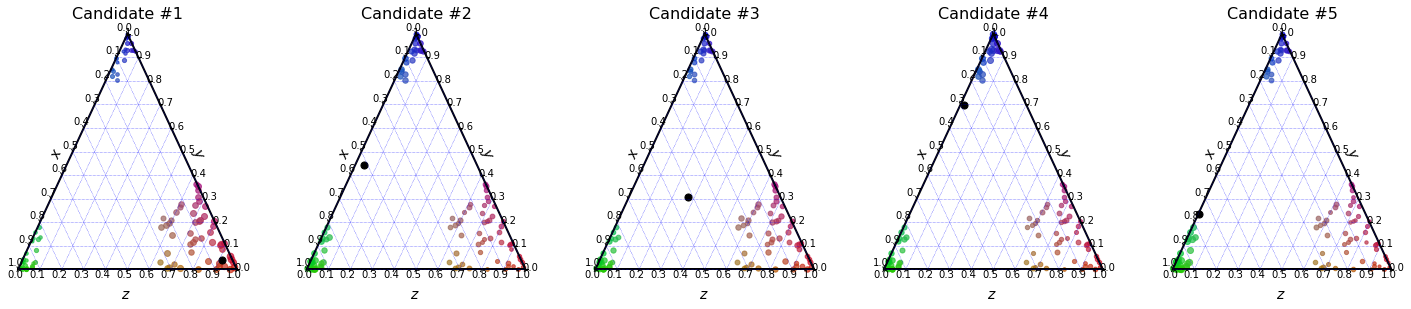

In [25]:
election = ev.FeaturesRule(profile)
election.plot_features("3D")
election.plot_features("ternary")


Then, we define its score as :

$$
S(c_j) = ||X_j||_2^2
$$

Scores :  [0.5132868626298664, 0.46133057230070856, 0.3901453367823402, 0.543734150706134, 0.5632018500610061]
Ranking :  [4, 3, 0, 1, 2]
Winner :  4
Welfare :  [0.7115682820284056, 0.4113409785608107, 0.0, 0.8875066937034373, 1.0]


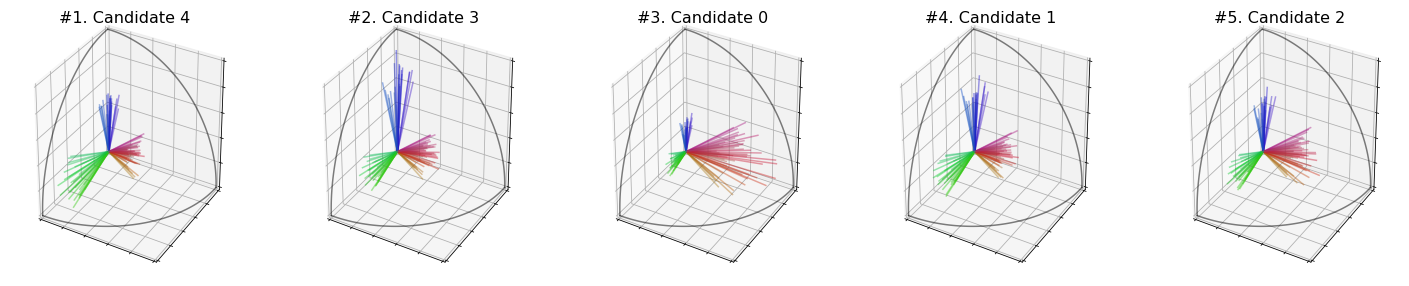

In [26]:
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)
election.plot_ranking("3D")